In [1]:
# Imports
#---------
import sys
import pandas as pd
import numpy as np
import feather
import os
import gc
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
import matplotlib.ticker as ticker
from matplotlib.dates import DateFormatter
import matplotlib as mpl
from datetime import timezone
import pickle

register_matplotlib_converters()

# File locations
#----------------
data_home = '/home/tonyb/Gdrive/MinicondaProjects/oxaria/data/raw/0oxaria/gap_filling/q12021/'
aurn_home = '/home/tonyb/Gdrive/MinicondaProjects/oxaria/data/aurn/'
pngs = '/home/tonyb/Gdrive/MinicondaProjects/oxaria/data/pngs/'

In [2]:
# Load latest 15-minute data from Brian
sebbes = pd.read_feather(aurn_home+'ox_auto_no2_pm_2019_2021_15m_oct21.ftr')

# Get St Ebbes 2020 only 
sebbes = sebbes[(sebbes['sitecode'] == 'OX8') & \
                (sebbes['rec'] >= dt.datetime(2020,1,1,tzinfo=dt.timezone.utc))]

# Load 15-minute data from Brian
highst = pd.read_feather(aurn_home+'ox_auto_no2_pm_2019_2021_15m_oct21.ftr')

# Get High St 2020 only 
highst = highst[(highst['sitecode'] == 'OX6') & \
                (highst['rec'] >= dt.datetime(2020,1,1,tzinfo=dt.timezone.utc))]

In [3]:
sebbes

,index,sitecode,name,rec,no_ppb,no2_ppb,pm10_ugg,o3_ppb,pm25_ugg,fidas_t,fidas_rh
231261,231261,OX8,Oxford St Ebbes,2020-01-01 00:15:00+00:00,0.67,12.28,36.299999,15.73,29.056700,6.2,91.500000
231262,231262,OX8,Oxford St Ebbes,2020-01-01 00:30:00+00:00,0.86,12.76,38.700001,13.41,33.113300,6.1,92.000000
231263,231263,OX8,Oxford St Ebbes,2020-01-01 00:45:00+00:00,0.67,12.95,40.700001,10.52,35.000099,6.1,91.900002
231264,231264,OX8,Oxford St Ebbes,2020-01-01 01:00:00+00:00,NaN,NaN,36.099998,9.17,30.660500,6.1,91.099998
231265,231265,OX8,Oxford St Ebbes,2020-01-01 01:15:00+00:00,NaN,NaN,36.900002,8.78,31.415199,5.9,90.699997
...,...,...,...,...,...,...,...,...,...,...,...
294328,294328,OX8,Oxford St Ebbes,2021-10-18 23:00:00+00:00,2.30,5.30,6.400000,NaN,2.830200,NaN,NaN
294329,294329,OX8,Oxford St Ebbes,2021-10-18 23:15:00+00:00,1.00,5.60,5.100000,NaN,2.075500,NaN,NaN
294330,294330,OX8,Oxford St Ebbes,2021-10-18 23:30:00+00:00,1.00,5.60,5.100000,NaN,2.075500,NaN,NaN
294331,294331,OX8,Oxford St Ebbes,2021-10-18 23:45:00+00:00,1.00,5.60,5.100000,NaN,2.075500,NaN,NaN


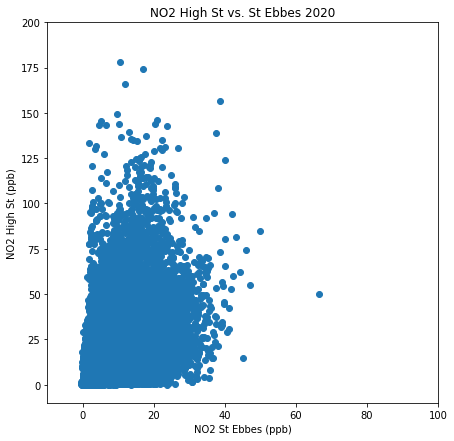

In [3]:
# Plotting just to compare high st vs st ebbes
#----------------------------------------------
plt.figure(figsize=(7,7))
plt.scatter(sebbes.no2_ppb, highst.no2_ppb)
plt.title('NO2 High St vs. St Ebbes 2020')
plt.ylabel('NO2 High St (ppb)')
plt.xlabel('NO2 St Ebbes (ppb)')
plt.ylim(-10,200)
plt.xlim(-10,100)
plt.savefig(pngs+'highst_vs_sebbes_no2_2020-21_oct21_update.png')

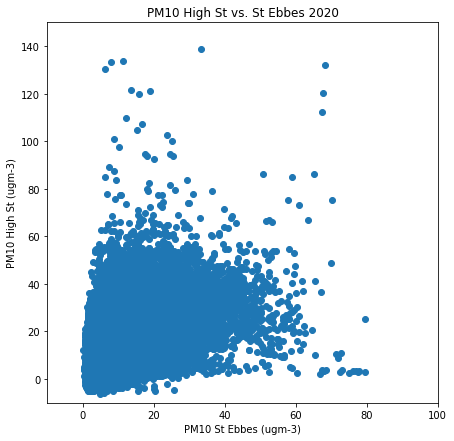

In [4]:
# Plotting just to compare high st vs st ebbes
#----------------------------------------------
plt.figure(figsize=(7,7))
plt.scatter(sebbes.pm10_ugg, highst.pm10_ugg)
plt.title('PM10 High St vs. St Ebbes 2020')
plt.ylabel('PM10 High St (ugm-3)')
plt.xlabel('PM10 St Ebbes (ugm-3)')
plt.ylim(-10,150)
plt.xlim(-10,100)
plt.savefig(pngs+'highst_vs_sebbes_pm10_2020-21_oct21_update.png')

In [6]:
# Merge St Ebbes & High St auto datasets & calc diff in no2 & pm10
#------------------------------------------------------------------
# Remove pm10_ugg <3 ugm-3 which persist because highst data are unratified
highst['pm10_ugg'] = np.where(highst['pm10_ugg'] < 3, np.nan, highst['pm10_ugg'])

# Merge
auto_merged = sebbes.merge(highst,on='rec',copy=True,suffixes=('_s','_h'))
# Calc absolute diffs of no2 & pm10
auto_merged['abs_no2_diff'] = abs(auto_merged['no2_ppb_s']-auto_merged['no2_ppb_h'])
auto_merged['abs_pm10_diff'] = abs(auto_merged['pm10_ugg_s']-auto_merged['pm10_ugg_h'])
# Get list of dates when diffs <=1ppb & 2ugm-3 respectively
convergent_no2 = list(auto_merged.query('abs_no2_diff <= 1')['rec'])
convergent_pm10 = list(auto_merged.query('abs_pm10_diff <= 2')['rec'])
auto_merged.to_feather(data_home+'auto_merged_ratified+2021_oct_update.ftr')

# Save lists as pickle files to be used later
with open(data_home+'convergent_datelist_no2+2021_oct_update.pkl', 'wb') as f:
    pickle.dump(convergent_no2, f)
    
with open(data_home+'convergent_datelist_pm10+2021_oct_update.pkl', 'wb') as f:
    pickle.dump(convergent_pm10, f)

# For info
print('Ratified data 2020, provisional jan to may 2021')
print('No.of 15min periods across Oxaria network where no2 diff is <= 2ugm-3: '+str(len(convergent_no2)))
print('No.of 15min periods across Oxaria network where pm10 diff is <= 2ugm-3: '+str(len(convergent_pm10)))


Ratified data 2020, provisional jan to may 2021
No.of 15min periods across Oxaria network where no2 diff is <= 2ugm-3: 6006
No.of 15min periods across Oxaria network where pm10 diff is <= 2ugm-3: 10182
